# FBT Entertainment Expense Classification Pipeline
## Rabobank Australia - FBT Year Ended 31 March 2025

This notebook provides a comprehensive ML pipeline to classify FBT-related expenses based on transaction descriptions.

### Classification Goals:
1. **Binary Classification**: Is the expense Meal Entertainment (ME)? (Y/N)
2. **Multi-class Classification**: What is the tax treatment category?

### Pipeline Overview:
1. Data Loading and Exploration
2. Data Preprocessing and Feature Engineering
3. Text Vectorization
4. Model Training and Comparison
5. Hyperparameter Tuning
6. Model Evaluation
7. Model Export and Inference

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ML Models (CPU only)
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
)
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, f1_score,
    ConfusionMatrixDisplay
)

# Pipeline and utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Imbalanced learning
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("Note: imbalanced-learn not available. Install with: pip install imbalanced-learn")

# Model persistence
import joblib
import pickle

print("All imports successful")
print(f"imbalanced-learn available: {IMBLEARN_AVAILABLE}")

All imports successful
imbalanced-learn available: True


## 2. Data Loading

In [16]:
RAW_DATA_PATH = 'data/data_raw_2024-25.xlsx'
WP_FILES = [
    'data/WP_1_Apr_to_Dec_24_FBT_ent_acc.xlsx',
    'data/WP_2_Apr_to_Dec_24_FBT_ent_acc.xlsx',
    'data/WP_3_Jan_to_Mar_25_FBT_ent_acc.xlsx',
    'data/WP_4_Jan_to_Mar_25_FBT_ent_acc.xlsx'
]

In [17]:
# Load raw data from all sheets
xl = pd.ExcelFile(RAW_DATA_PATH)
print(f"Available sheets in raw data: {xl.sheet_names}")

raw_dfs = []
for sheet in xl.sheet_names:
    df = pd.read_excel(RAW_DATA_PATH, sheet_name=sheet)
    df['SOURCE_SHEET'] = sheet
    raw_dfs.append(df)
    
raw_data = pd.concat(raw_dfs, ignore_index=True)
print(f"\nRaw data shape: {raw_data.shape}")
print(f"Columns: {list(raw_data.columns)}")

Available sheets in raw data: ['5130006000', '5130002000', '5130005000', '5130004000', '5130001000', '5130003000', '5140001010', '5140001030', '5160001000', '5160007000', '5160008000', '5160010000', '5160011000', 'Misc']

Raw data shape: (47391, 16)
Columns: ['BUSINESS_UNIT_CODE', 'OPERATING_UNIT_CODE', 'ACCOUNT_CODE', 'DESCRIPTION', 'BASE_AMOUNT', 'BASE_CURRENCY_CODE', 'JOURNAL_DATE', 'DESCR', 'LINE_DESCR', 'PURPOSE', 'INVOICE_DESCR', 'INVOICE_ID', 'VENDOR_NAME', 'EMPLOYEE_NAME', 'CHARGE_DESCRIPTION', 'SOURCE_SHEET']


In [18]:
raw_data.head()

,BUSINESS_UNIT_CODE,OPERATING_UNIT_CODE,ACCOUNT_CODE,DESCRIPTION,BASE_AMOUNT,BASE_CURRENCY_CODE,JOURNAL_DATE,DESCR,LINE_DESCR,PURPOSE,INVOICE_DESCR,INVOICE_ID,VENDOR_NAME,EMPLOYEE_NAME,CHARGE_DESCRIPTION,SOURCE_SHEET
0,AU052,AU030510,5130006000,Entertainment expense,12.50,AUQ,2024-04-02 00:00:00,CCMS,DuftyW-Default Licensee Mercha,Gym Expense in Horsham visiting clients - Will...,NaN,NaN,NaN,NaN,YMCA HORSHAM AQUATIC,5130006000
1,AU052,AU010010,5130006000,Entertainment expense,43.32,AUQ,2024-04-03 00:00:00,CCMS,AuYeungS-Entertainment Expense,Work travel to NL - work travel - Julie Habets,NaN,NaN,NaN,NaN,KEUKENHOF B.V.,5130006000
2,AU052,AU010010,5130006000,Entertainment expense,43.32,AUQ,2024-04-03 00:00:00,CCMS,AuYeungS-Entertainment Expense,Work travel to NL - work travel - Lach Monsbourgh,NaN,NaN,NaN,NaN,KEUKENHOF B.V.,5130006000
3,AU052,AU010010,5130006000,Entertainment expense,43.32,AUQ,2024-04-03 00:00:00,CCMS,AuYeungS-Entertainment Expense,Work travel to NL - work travel - Sophie Terhorst,NaN,NaN,NaN,NaN,KEUKENHOF B.V.,5130006000
4,AU052,AU010010,5130006000,Entertainment expense,43.32,AUQ,2024-04-03 00:00:00,CCMS,AuYeungS-Entertainment Expense,Work travel to NL - work travel - Susan Au Yeung,NaN,NaN,NaN,NaN,KEUKENHOF B.V.,5130006000


In [19]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47391 entries, 0 to 47390
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BUSINESS_UNIT_CODE   47391 non-null  object 
 1   OPERATING_UNIT_CODE  47391 non-null  object 
 2   ACCOUNT_CODE         47391 non-null  int64  
 3   DESCRIPTION          47391 non-null  object 
 4   BASE_AMOUNT          47391 non-null  float64
 5   BASE_CURRENCY_CODE   47391 non-null  object 
 6   JOURNAL_DATE         47391 non-null  object 
 7   DESCR                47368 non-null  object 
 8   LINE_DESCR           47375 non-null  object 
 9   PURPOSE              41567 non-null  object 
 10  INVOICE_DESCR        3410 non-null   object 
 11  INVOICE_ID           3420 non-null   object 
 12  VENDOR_NAME          3649 non-null   object 
 13  EMPLOYEE_NAME        0 non-null      float64
 14  CHARGE_DESCRIPTION   41444 non-null  object 
 15  SOURCE_SHEET         47391 non-null 

## 3. Load Labeled Data from Workpapers

In [21]:
def parse_workpaper_sheet(filepath, sheet_name):
    """
    Parse a single workpaper sheet to extract labeled transactions.
    Returns DataFrame with standardized columns and labels.
    """
    try:
        df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)
        
        # Find header row containing BUSINESS_UNIT_CODE
        header_idx = None
        for i, row in df.iterrows():
            row_values = [str(v).upper() for v in row.values if pd.notna(v)]
            if any('BUSINESS_UNIT_CODE' in v for v in row_values):
                header_idx = i
                break
        
        if header_idx is None:
            return None
        
        # Set proper headers
        headers = df.iloc[header_idx].tolist()
        df = df.iloc[header_idx + 1:].reset_index(drop=True)
        df.columns = headers
        
        # Clean column names
        df.columns = [str(c).strip() if pd.notna(c) else f'col_{i}' 
                      for i, c in enumerate(df.columns)]
        
        # Find label columns
        label_cols = {}
        for col in df.columns:
            col_lower = str(col).lower()
            if 'tax' in col_lower and 'desc' in col_lower:
                label_cols['tax_description'] = col
            elif 'me?' in col_lower or col_lower.strip() == 'me':
                label_cols['me_label'] = col
        
        # Add metadata
        df['_source_file'] = filepath
        df['_source_sheet'] = sheet_name
        df['_has_labels'] = len(label_cols) > 0
        
        # Standardize label column names
        for std_name, orig_name in label_cols.items():
            if orig_name in df.columns:
                df[std_name] = df[orig_name]
        
        return df
        
    except Exception as e:
        print(f"Error parsing {filepath} - {sheet_name}: {e}")
        return None

In [22]:
def load_all_workpapers(wp_files):
    """
    Load and combine all workpaper files.
    """
    all_dfs = []
    
    for filepath in wp_files:
        print(f"\nProcessing: {filepath}")
        try:
            xl = pd.ExcelFile(filepath)
            for sheet in xl.sheet_names:
                if sheet.lower() in ['summary', 'trial balance - jan to mar 25']:
                    continue
                
                df = parse_workpaper_sheet(filepath, sheet)
                if df is not None and len(df) > 0:
                    print(f"  - {sheet}: {len(df)} rows, has_labels={df['_has_labels'].iloc[0]}")
                    all_dfs.append(df)
        except Exception as e:
            print(f"  Error: {e}")
    
    if not all_dfs:
        return pd.DataFrame()
    
    # Combine all DataFrames
    combined = pd.concat(all_dfs, ignore_index=True)
    print(f"\nTotal combined rows: {len(combined)}")
    return combined

In [23]:
# Load all workpapers
labeled_data = load_all_workpapers(WP_FILES)


Processing: data/WP_1_Apr_to_Dec_24_FBT_ent_acc.xlsx
  - Travel&lodging: 33218 rows, has_labels=True
  - Meals Exp: 22080 rows, has_labels=True
  - Lodging Exp: 3083 rows, has_labels=True
  - Dom Pub Trnsprt: 3699 rows, has_labels=True
  - Travel Exp Abroad: 1013 rows, has_labels=True
  - Ent Exp: 163 rows, has_labels=True

Processing: data/WP_2_Apr_to_Dec_24_FBT_ent_acc.xlsx
  - Ext Training: 296 rows, has_labels=True
  - Training Travel&lodging: 101 rows, has_labels=True
  - Publicity&Advertising: 401 rows, has_labels=True
  - Sponsoring: 70 rows, has_labels=True
  - Promotional gifts: 38 rows, has_labels=True
  - Marketing exp: 183 rows, has_labels=True
  - Business Dev: 1104 rows, has_labels=True
  - Public relations: 37 rows, has_labels=True
  - Membership: 224 rows, has_labels=True
  - Meeting costs: 154 rows, has_labels=True
  - Misc exp: 377 rows, has_labels=True
  - Sundry exp: 28 rows, has_labels=True
  - Misc exp (2): 1229 rows, has_labels=True
  - Other non-bank exp: 224 r

In [24]:
# Check for label columns
print("Columns containing labels:")
for col in labeled_data.columns:
    if 'tax' in col.lower() or 'me' in col.lower():
        print(f"  {col}: {labeled_data[col].nunique()} unique values")

Columns containing labels:
  VENDOR_NAME: 1081 unique values
  EMPLOYEE_NAME: 0 unique values
  Tax Description: 211 unique values
  ME?

Y/N: 5 unique values
  ME

$: 2998 unique values
  Not ME but other type of FB
Y/N: 1 unique values
  Not ME but other type of FB ==>
$: 3 unique values
  ME: 0 unique values
  Additional Comments: 1 unique values
  tax_description: 211 unique values
  me_label: 0 unique values
  Recreational Non Meal Entertainment: 1 unique values


## 4. Data Exploration

In [25]:
# Explore expense descriptions
print("Unique DESCRIPTION values:")
print(raw_data['DESCRIPTION'].value_counts())

Unique DESCRIPTION values:
DESCRIPTION
Meals expense                     27108
Domestic public transport exp      4347
Lodging expense                    3673
Travel & Lodging (excl Lease)      3097
Other office expenses              2404
Miscellaneous expenses             1826
Business development               1311
Travelling expense abroad          1165
Publicity/advertising               570
External Training and Seminars      349
Contributions& club membershi       262
Marketing expense                   247
Entertainment expense               224
Meeting costs                       207
Other non banking expenses          180
Training travel and lodging ex      114
Donations                            82
Sponsoring                           76
Promotional gifts                    48
Public relations                     46
Sundry expenses                      28
Client periodicals/magazines         27
Name: count, dtype: int64


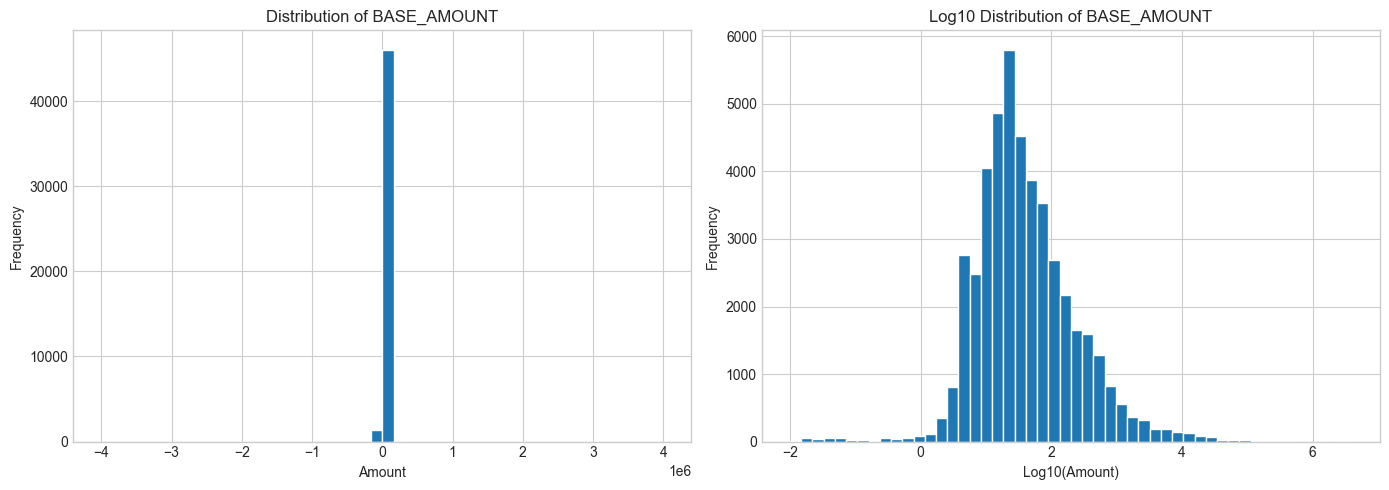

In [26]:
# Explore amount distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of amounts
raw_data['BASE_AMOUNT'].hist(bins=50, ax=axes[0])
axes[0].set_title('Distribution of BASE_AMOUNT')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Log distribution
raw_data[raw_data['BASE_AMOUNT'] > 0]['BASE_AMOUNT'].apply(np.log10).hist(bins=50, ax=axes[1])
axes[1].set_title('Log10 Distribution of BASE_AMOUNT')
axes[1].set_xlabel('Log10(Amount)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
# Explore text fields
print("Sample PURPOSE values:")
print(raw_data['PURPOSE'].dropna().head(20).tolist())

Sample PURPOSE values:
['Gym Expense in Horsham visiting clients - William Dufty', 'Work travel to NL - work travel - Julie Habets', 'Work travel to NL - work travel - Lach Monsbourgh', 'Work travel to NL - work travel - Sophie Terhorst', 'Work travel to NL - work travel - Susan Au Yeung', 'Entry Ticket - Tullibigeal Picnic Races - Bernard Connolly', 'Balance for March Activity - CFO Domain', 'Farm World Ticket - Tom Cohen', 'Farmworld Tickets - Zoe Rotthier', 'Beef Week Engagement MP/Media - Steve Batten', 'FArm World ticket Matthew LOng - Matthew Long', 'Fiona Looker Farm World Ticket - Fiona Looker', 'NTCA Tickets x3 - Barry Gerschwitz', 'NTCA Tickets x3 - Joe Webb', 'NTCA Tickets x3 - Gavin Kruger', 'Beef Week - Entry fee for 2 days - ANTHONY BARAKAT', 'Teambuilding - Risk & Compliance FLRS - Greg Pang', 'Teambuilding - Risk & Compliance FLRS - Jolene Janzen', 'Teambuilding - Risk & Compliance FLRS - Ruby Samad', 'Teambuilding - Risk & Compliance FLRS - Tina Alonso']


In [28]:
print("\nSample CHARGE_DESCRIPTION values:")
print(raw_data['CHARGE_DESCRIPTION'].dropna().head(20).tolist())


Sample CHARGE_DESCRIPTION values:
['YMCA HORSHAM AQUATIC', 'KEUKENHOF B.V.', 'KEUKENHOF B.V.', 'KEUKENHOF B.V.', 'KEUKENHOF B.V.', '123TIX*TULLIBIGEAL PIC', 'STRIKE BOWLING', 'LARDNER PA* FARM WORLD', 'LARDNER PA* FARM WORLD', 'BEEFAUS* BEEFAUS24 TIX', 'LARDNER PA* FARM WORLD', 'LARDNER PA* FARM WORLD', 'AA&P EVENTS', 'AA&P EVENTS', 'AA&P EVENTS', 'BEEFAUS* BEEFAUS24 TIX', 'WWW.MANIAX.COM.AU', 'WWW.MANIAX.COM.AU', 'WWW.MANIAX.COM.AU', 'WWW.MANIAX.COM.AU']


In [29]:
print("\nSample LINE_DESCR values:")
print(raw_data['LINE_DESCR'].dropna().head(20).tolist())


Sample LINE_DESCR values:
['DuftyW-Default Licensee Mercha', 'AuYeungS-Entertainment Expense', 'AuYeungS-Entertainment Expense', 'AuYeungS-Entertainment Expense', 'AuYeungS-Entertainment Expense', 'CONNOLLYB-Entertainment Expens', 'CLEMENTSP-Offshore Meals & Lod', 'CohenT-Entertainment Expense', 'RotthierZ-Entertainment Expens', 'BattenS-Entertainment Expense', 'LongM1-Entertainment Expense', 'LongM1-Entertainment Expense', 'EdmondsE-Default Licensee Merc', 'EdmondsE-Default Licensee Merc', 'EdmondsE-Default Licensee Merc', 'BARAKATA-Entertainment Expense', 'JanzenJ-Entertainment Expense', 'JanzenJ-Entertainment Expense', 'JanzenJ-Entertainment Expense', 'JanzenJ-Entertainment Expense']


## 5. Feature Engineering

In [30]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Custom text preprocessor for FBT expense descriptions.
    """
    def __init__(self, lowercase=True, remove_numbers=False, 
                 remove_special_chars=True, min_length=2):
        self.lowercase = lowercase
        self.remove_numbers = remove_numbers
        self.remove_special_chars = remove_special_chars
        self.min_length = min_length
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self._clean_text(text) for text in X]
    
    def _clean_text(self, text):
        if pd.isna(text):
            return ''
        
        text = str(text)
        
        if self.lowercase:
            text = text.lower()
        
        if self.remove_special_chars:
            text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        # Filter short tokens
        tokens = [t for t in text.split() if len(t) >= self.min_length]
        
        return ' '.join(tokens)

In [31]:
def create_combined_text(df):
    """
    Combine multiple text columns into a single feature.
    """
    text_columns = ['PURPOSE', 'CHARGE_DESCRIPTION', 'LINE_DESCR', 
                    'DESCRIPTION', 'INVOICE_DESCR', 'VENDOR_NAME']
    
    available_cols = [c for c in text_columns if c in df.columns]
    
    def combine_row(row):
        parts = []
        for col in available_cols:
            val = row.get(col, '')
            if pd.notna(val) and str(val).strip():
                parts.append(str(val).strip())
        return ' '.join(parts)
    
    return df.apply(combine_row, axis=1)

In [32]:
def extract_features(df):
    """
    Extract numerical and categorical features from transaction data.
    """
    features = pd.DataFrame(index=df.index)
    
    # Amount features
    if 'BASE_AMOUNT' in df.columns:
        features['amount'] = df['BASE_AMOUNT'].fillna(0)
        features['amount_log'] = np.log1p(np.abs(df['BASE_AMOUNT'].fillna(0)))
        features['amount_negative'] = (df['BASE_AMOUNT'] < 0).astype(int)
    
    # Date features
    if 'JOURNAL_DATE' in df.columns:
        dates = pd.to_datetime(df['JOURNAL_DATE'], errors='coerce')
        features['month'] = dates.dt.month.fillna(0).astype(int)
        features['day_of_week'] = dates.dt.dayofweek.fillna(0).astype(int)
        features['quarter'] = dates.dt.quarter.fillna(0).astype(int)
        features['is_weekend'] = dates.dt.dayofweek.isin([5, 6]).astype(int)
    
    # Account code features
    if 'ACCOUNT_CODE' in df.columns:
        features['account_code'] = df['ACCOUNT_CODE'].astype(str)
    
    # Text length features
    for col in ['PURPOSE', 'CHARGE_DESCRIPTION', 'LINE_DESCR']:
        if col in df.columns:
            features[f'{col.lower()}_length'] = df[col].fillna('').astype(str).str.len()
            features[f'{col.lower()}_word_count'] = df[col].fillna('').astype(str).str.split().str.len()
    
    return features

In [33]:
# Create combined text feature
raw_data['combined_text'] = create_combined_text(raw_data)

# Extract numerical features
numerical_features = extract_features(raw_data)

print(f"Combined text sample:")
print(raw_data['combined_text'].head(3).tolist())
print(f"\nNumerical features shape: {numerical_features.shape}")
print(f"Numerical features: {list(numerical_features.columns)}")

Combined text sample:
['Gym Expense in Horsham visiting clients - William Dufty YMCA HORSHAM AQUATIC DuftyW-Default Licensee Mercha Entertainment expense', 'Work travel to NL - work travel - Julie Habets KEUKENHOF B.V. AuYeungS-Entertainment Expense Entertainment expense', 'Work travel to NL - work travel - Lach Monsbourgh KEUKENHOF B.V. AuYeungS-Entertainment Expense Entertainment expense']

Numerical features shape: (47391, 14)
Numerical features: ['amount', 'amount_log', 'amount_negative', 'month', 'day_of_week', 'quarter', 'is_weekend', 'account_code', 'purpose_length', 'purpose_word_count', 'charge_description_length', 'charge_description_word_count', 'line_descr_length', 'line_descr_word_count']


## 6. Prepare Training Data

Since the workpapers contain labeled data, we need to extract and prepare it for training.

In [34]:
def prepare_labeled_dataset(labeled_df):
    """
    Prepare the labeled dataset for training.
    Returns X (features), y (labels), and metadata.
    """
    # Filter rows with labels
    if 'me_label' in labeled_df.columns:
        # Clean ME labels
        labeled_df['me_clean'] = labeled_df['me_label'].astype(str).str.strip().str.upper()
        labeled_df['me_clean'] = labeled_df['me_clean'].replace({'NAN': np.nan, 'NONE': np.nan, '': np.nan})
        
        # Keep only valid labels
        valid_labels = labeled_df['me_clean'].isin(['Y', 'N'])
        labeled_df = labeled_df[valid_labels].copy()
        
        print(f"Rows with valid ME labels: {len(labeled_df)}")
        print(f"Label distribution:\n{labeled_df['me_clean'].value_counts()}")
    
    if 'tax_description' in labeled_df.columns:
        print(f"\nTax description distribution:")
        print(labeled_df['tax_description'].value_counts().head(20))
    
    return labeled_df

In [35]:
# Prepare labeled data
if len(labeled_data) > 0:
    training_data = prepare_labeled_dataset(labeled_data)
else:
    print("No labeled data found. Creating synthetic labels based on rules.")
    training_data = raw_data.copy()

Rows with valid ME labels: 0
Label distribution:
Series([], Name: count, dtype: int64)

Tax description distribution:
Series([], Name: count, dtype: int64)


## 7. Rule-Based Label Generation (if needed)

If labeled data is insufficient, we can create rules-based labels for initial training.

In [36]:
def create_rule_based_labels(df):
    """
    Create labels based on business rules for FBT classification.
    These are heuristic labels that should be validated.
    """
    df = df.copy()
    combined_text = df['combined_text'].fillna('').str.lower()
    
    # Entertainment keywords (likely ME = Y)
    entertainment_keywords = [
        'dinner', 'lunch', 'breakfast', 'meal', 'restaurant', 'catering',
        'entertainment', 'event', 'party', 'celebration', 'christmas', 'xmas',
        'farewell', 'welcome', 'function', 'drinks', 'alcohol', 'wine', 'beer',
        'client dinner', 'team dinner', 'staff dinner', 'offsite dinner'
    ]
    
    # Non-entertainment keywords (likely ME = N)
    non_entertainment_keywords = [
        'training', 'conference', 'seminar', 'workshop', 'course',
        'travel', 'flight', 'taxi', 'uber', 'accommodation', 'hotel',
        'parking', 'toll', 'fuel', 'petrol', 'airfare',
        'subscription', 'membership', 'software', 'equipment'
    ]
    
    # Team building / recreational (58P - no FBT but non-deductible)
    recreation_keywords = [
        'team building', 'teambuilding', 'fun day', 'activity day',
        'bowling', 'golf', 'sailing', 'escape room', 'axe throwing'
    ]
    
    # Initialize labels
    df['rule_label'] = 'UNKNOWN'
    
    # Apply rules
    for keyword in entertainment_keywords:
        mask = combined_text.str.contains(keyword, na=False)
        df.loc[mask, 'rule_label'] = 'ME'
    
    for keyword in non_entertainment_keywords:
        mask = combined_text.str.contains(keyword, na=False)
        df.loc[mask & (df['rule_label'] == 'UNKNOWN'), 'rule_label'] = 'NOT_ME'
    
    for keyword in recreation_keywords:
        mask = combined_text.str.contains(keyword, na=False)
        df.loc[mask, 'rule_label'] = 'RECREATION_58P'
    
    # Account code based rules
    if 'ACCOUNT_CODE' in df.columns:
        # Entertainment expense account
        df.loc[df['ACCOUNT_CODE'] == 5130006000, 'rule_label'] = df.loc[
            df['ACCOUNT_CODE'] == 5130006000, 'rule_label'
        ].replace('UNKNOWN', 'ME')
        
        # Meals expense account
        df.loc[df['ACCOUNT_CODE'] == 5130004000, 'rule_label'] = df.loc[
            df['ACCOUNT_CODE'] == 5130004000, 'rule_label'
        ].replace('UNKNOWN', 'REVIEW')
    
    print("Rule-based label distribution:")
    print(df['rule_label'].value_counts())
    
    return df

In [37]:
# Apply rule-based labeling to raw data
raw_data_labeled = create_rule_based_labels(raw_data)

Rule-based label distribution:
rule_label
ME                29709
NOT_ME            10985
UNKNOWN            6440
RECREATION_58P      257
Name: count, dtype: int64


## 8. Build Classification Pipeline

In [38]:
# Prepare data for training
# Use rule-based labels if no manual labels available

# Filter to known labels only
train_df = raw_data_labeled[raw_data_labeled['rule_label'].isin(['ME', 'NOT_ME', 'RECREATION_58P'])].copy()
print(f"Training samples: {len(train_df)}")
print(f"Label distribution:\n{train_df['rule_label'].value_counts()}")

Training samples: 40951
Label distribution:
rule_label
ME                29709
NOT_ME            10985
RECREATION_58P      257
Name: count, dtype: int64


In [39]:
# Prepare features and labels
X_text = train_df['combined_text'].values
y = train_df['rule_label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")

Classes: ['ME' 'NOT_ME' 'RECREATION_58P']
Encoded labels: [0 1 2]


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

## 9. Text Vectorization

In [ ]:
# TF-IDF Vectorizer with n-grams
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

# Fit and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

In [ ]:
# Show top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Sample features: {feature_names[:20].tolist()}")

## 10. Model Training and Comparison

In [ ]:
# Define models to compare (all CPU-based)
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    'Multinomial NB': MultinomialNB(alpha=0.1),
    'Complement NB': ComplementNB(alpha=0.1),
    'Linear SVC': LinearSVC(
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    'SGD Classifier': SGDClassifier(
        loss='modified_huber', max_iter=1000, random_state=42, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=20, random_state=42, 
        class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100, max_depth=20, random_state=42,
        class_weight='balanced', n_jobs=-1
    )
}

In [ ]:
# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train_tfidf, y_train, cv=5, scoring='f1_weighted'
    )
    
    # Train on full training set
    model.fit(X_train_tfidf, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'CV Mean F1': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': accuracy,
        'Test F1': f1
    })
    
    print(f"  CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test F1: {f1:.4f}")

In [ ]:
# Results comparison
results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)
print("\nModel Comparison:")
print(results_df.to_string(index=False))

In [ ]:
# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['CV Mean F1'], width, label='CV F1', alpha=0.8)
bars2 = ax.bar(x + width/2, results_df['Test F1'], width, label='Test F1', alpha=0.8)

ax.set_ylabel('F1 Score')
ax.set_title('Model Comparison - F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 11. Best Model Analysis

In [ ]:
# Select best model based on Test F1
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")

# Detailed classification report
y_pred = best_model.predict(X_test_tfidf)
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred, target_names=label_encoder.classes_
))

In [ ]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

## 12. Feature Importance Analysis

In [ ]:
def get_feature_importance(model, feature_names, top_n=20):
    """
    Extract feature importance from different model types.
    """
    if hasattr(model, 'coef_'):
        # For linear models (Logistic Regression, SVC, etc.)
        if len(model.coef_.shape) == 1:
            importance = np.abs(model.coef_)
        else:
            importance = np.abs(model.coef_).mean(axis=0)
    elif hasattr(model, 'feature_importances_'):
        # For tree-based models
        importance = model.feature_importances_
    else:
        return None
    
    # Get top features
    indices = np.argsort(importance)[-top_n:][::-1]
    top_features = [(feature_names[i], importance[i]) for i in indices]
    
    return top_features

In [ ]:
# Get feature importance for best model
top_features = get_feature_importance(best_model, feature_names, top_n=30)

if top_features:
    print(f"\nTop 30 Features for {best_model_name}:")
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"{i:2d}. {feature:30s} {importance:.4f}")

In [ ]:
# Visualize feature importance
if top_features:
    features, importances = zip(*top_features[:20])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    y_pos = np.arange(len(features))
    
    ax.barh(y_pos, importances, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title(f'Top 20 Features - {best_model_name}')
    
    plt.tight_layout()
    plt.show()

## 13. Hyperparameter Tuning

In [ ]:
# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

# Grid search
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    param_grid_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV for Logistic Regression...")
grid_search_lr.fit(X_train_tfidf, y_train)

print(f"\nBest parameters: {grid_search_lr.best_params_}")
print(f"Best CV score: {grid_search_lr.best_score_:.4f}")

In [ ]:
# Evaluate tuned model
best_lr = grid_search_lr.best_estimator_
y_pred_tuned = best_lr.predict(X_test_tfidf)

print("\nTuned Logistic Regression Results:")
print(classification_report(
    y_test, y_pred_tuned, target_names=label_encoder.classes_
))

## 14. Ensemble Model

In [ ]:
# Create voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')),
        ('nb', ComplementNB(alpha=0.1)),
        ('svc', LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1))
    ],
    voting='hard'
)

print("Training Ensemble...")
ensemble.fit(X_train_tfidf, y_train)

y_pred_ensemble = ensemble.predict(X_test_tfidf)

print("\nEnsemble Results:")
print(classification_report(
    y_test, y_pred_ensemble, target_names=label_encoder.classes_
))

## 15. Final Pipeline Creation

In [ ]:
# Create complete pipeline
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
        strip_accents='unicode',
        lowercase=True
    )),
    ('classifier', LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        class_weight='balanced',
        **grid_search_lr.best_params_
    ))
])

# Train on full dataset
final_pipeline.fit(X_text, y_encoded)

print("Final pipeline trained successfully")

## 16. Model Export

In [ ]:
# Save the pipeline and encoder
MODEL_PATH = 'fbt_classifier_pipeline.joblib'
ENCODER_PATH = 'fbt_label_encoder.joblib'

joblib.dump(final_pipeline, MODEL_PATH)
joblib.dump(label_encoder, ENCODER_PATH)

print(f"Pipeline saved to: {MODEL_PATH}")
print(f"Label encoder saved to: {ENCODER_PATH}")

## 17. Inference Function

In [ ]:
def predict_fbt_classification(texts, pipeline_path='fbt_classifier_pipeline.joblib',
                                encoder_path='fbt_label_encoder.joblib'):
    """
    Predict FBT classification for new expense descriptions.
    
    Parameters:
    -----------
    texts : list or str
        Expense description text(s) to classify
    
    Returns:
    --------
    DataFrame with predictions and probabilities
    """
    # Load model
    pipeline = joblib.load(pipeline_path)
    encoder = joblib.load(encoder_path)
    
    # Handle single text input
    if isinstance(texts, str):
        texts = [texts]
    
    # Predict
    predictions = pipeline.predict(texts)
    labels = encoder.inverse_transform(predictions)
    
    # Get probabilities if available
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        probabilities = pipeline.predict_proba(texts)
        prob_df = pd.DataFrame(
            probabilities, 
            columns=[f'prob_{c}' for c in encoder.classes_]
        )
    else:
        prob_df = pd.DataFrame()
    
    # Create results DataFrame
    results = pd.DataFrame({
        'text': texts,
        'prediction': labels
    })
    
    if not prob_df.empty:
        results = pd.concat([results, prob_df], axis=1)
    
    return results

In [ ]:
# Test inference
test_texts = [
    "Client dinner at restaurant with 5 partners",
    "Taxi to airport for business trip",
    "Team building activity - bowling",
    "Training seminar registration fee",
    "Christmas party catering for staff"
]

predictions = predict_fbt_classification(test_texts)
print("\nSample Predictions:")
print(predictions.to_string(index=False))

## 18. Batch Prediction on Raw Data

In [ ]:
# Predict on all raw data
raw_data['ml_prediction'] = final_pipeline.predict(raw_data['combined_text'])
raw_data['ml_prediction_label'] = label_encoder.inverse_transform(raw_data['ml_prediction'])

# Get probabilities
if hasattr(final_pipeline.named_steps['classifier'], 'predict_proba'):
    probs = final_pipeline.predict_proba(raw_data['combined_text'])
    for i, class_name in enumerate(label_encoder.classes_):
        raw_data[f'prob_{class_name}'] = probs[:, i]

print("\nPrediction Distribution:")
print(raw_data['ml_prediction_label'].value_counts())

In [ ]:
# Export predictions
output_cols = ['BUSINESS_UNIT_CODE', 'OPERATING_UNIT_CODE', 'ACCOUNT_CODE', 
               'DESCRIPTION', 'BASE_AMOUNT', 'JOURNAL_DATE', 'PURPOSE',
               'CHARGE_DESCRIPTION', 'combined_text', 'ml_prediction_label']

# Add probability columns if available
prob_cols = [c for c in raw_data.columns if c.startswith('prob_')]
output_cols.extend(prob_cols)

# Filter to available columns
output_cols = [c for c in output_cols if c in raw_data.columns]

raw_data[output_cols].to_csv('fbt_predictions.csv', index=False)
print("Predictions exported to: fbt_predictions.csv")

## 19. Summary and Next Steps

In [ ]:
print("="*60)
print("PIPELINE SUMMARY")
print("="*60)
print(f"\nTotal samples processed: {len(raw_data)}")
print(f"Training samples used: {len(train_df)}")
print(f"Features extracted: {X_train_tfidf.shape[1]}")
print(f"\nBest performing model: {best_model_name}")
print(f"Test F1 Score: {results_df.iloc[0]['Test F1']:.4f}")
print(f"\nFiles saved:")
print(f"  - {MODEL_PATH}")
print(f"  - {ENCODER_PATH}")
print(f"  - fbt_predictions.csv")

---

## Appendix: Additional Utilities

In [ ]:
def analyze_misclassifications(X_test, y_test, y_pred, label_encoder, n_samples=10):
    """
    Analyze misclassified samples to understand model errors.
    """
    misclassified_idx = np.where(y_test != y_pred)[0]
    
    print(f"Total misclassified: {len(misclassified_idx)} / {len(y_test)}")
    print(f"Error rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")
    print(f"\nSample misclassifications:")
    print("-" * 80)
    
    for idx in misclassified_idx[:n_samples]:
        print(f"Text: {X_test[idx][:100]}...")
        print(f"True: {label_encoder.classes_[y_test[idx]]}")
        print(f"Predicted: {label_encoder.classes_[y_pred[idx]]}")
        print("-" * 80)

In [ ]:
# Analyze misclassifications for best model
y_pred_best = best_model.predict(X_test_tfidf)
analyze_misclassifications(X_test, y_test, y_pred_best, label_encoder)

In [ ]:
def get_prediction_confidence(pipeline, texts, threshold=0.7):
    """
    Get predictions with confidence scores and flag low-confidence predictions.
    """
    if isinstance(texts, str):
        texts = [texts]
    
    predictions = pipeline.predict(texts)
    
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        probs = pipeline.predict_proba(texts)
        confidence = probs.max(axis=1)
        needs_review = confidence < threshold
    else:
        confidence = np.ones(len(texts))
        needs_review = np.zeros(len(texts), dtype=bool)
    
    return pd.DataFrame({
        'text': texts,
        'prediction': predictions,
        'confidence': confidence,
        'needs_review': needs_review
    })

In [ ]:
# Example: Get predictions with confidence
confidence_results = get_prediction_confidence(final_pipeline, test_texts)
print("\nPredictions with Confidence:")
print(confidence_results.to_string(index=False))